In [1]:
import os

import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from softce_validation.tasks.available_tasks import get_available_tasks
from softce_validation.utils import get_abspath_project_root

os.chdir(get_abspath_project_root())

plt.style.use('./plots/style.mplstyle')

palette = {
    "SoftCE": "#CA8B33",
    "ELBO": "#275A88",
    "IWAE": "#845B97",
}

tasks = get_available_tasks()

method_names = list(palette.keys())

In [2]:
metric_names = [
    "mean_log_prob_reference",
    "negative_posterior_mean_l2",
    "coverage_probabilities",
]

results = {task_name: {method_name: [] for method_name in method_names} for task_name in tasks.keys()}


for task_name in tasks.keys():
    for method_name in method_names:
        files = [f for f in os.listdir(f"results/{task_name}") if method_name in f]
        for file in files:
            results[task_name][method_name].append(dict(np.load(f"results/{task_name}/{file}")))

for task_name in tasks.keys():
    for method_name in method_names:
        results[task_name][method_name] = {
            metric_name: np.stack([run[metric_name] for run in results[task_name][method_name] if "negative_posterior_mean_l2" in run.keys()]) for metric_name in metric_names
        } # TODO simplify


plot_task_names = {
    "eight_schools": "Eight\nSchools",
    "linear_regression": "Linear\nRegression",
    "slcp": "SLCP",
}

results = {new: results[old] for old, new in plot_task_names.items()}            

/tmp/ipykernel_204290/2172414363.py:96: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


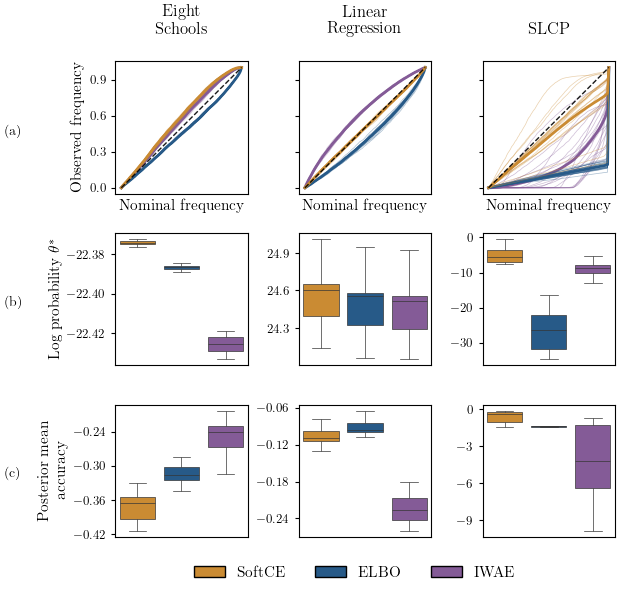

In [6]:
fig = plt.figure(layout='constrained', figsize=(7, 5.15))
subfigs = fig.subfigures(nrows=3, ncols=1)

####### Coverage #######
axes0 = subfigs[0].subplots(ncols=len(results), sharey=True)

nominal_frequency = np.linspace(0, 1, 100)

for (task_name, task_result), ax in zip(results.items(), axes0, strict=False):
    ax.set_title(task_name, y=1.15)
    ax.set_xlabel("Nominal frequency")

    for method_name in reversed(method_names):
        coverage_probs = task_result[method_name]["coverage_probabilities"]

        ax.plot(
            nominal_frequency,
            coverage_probs.mean(axis=0),
            color=palette[method_name],
            linewidth=2,
            )

        ax.plot(
            nominal_frequency,
            coverage_probs.T,
            color=palette[method_name],
            linewidth=0.5,
            alpha=0.4,
            )
    ax.plot([0, 1], [0, 1], color="black", linewidth=1, alpha=0.9,  linestyle="--")

        

####### log prob true #######

axes1 = subfigs[1].subplots(ncols=len(results))

box_kwargs = {
    "showfliers": False,
    "palette": palette,
    "saturation": 1,
    "linewidth": 0.5,
}

for task_result, ax in zip(results.values(), axes1, strict=True):
    df = pd.DataFrame(
        {method_name: task_result[method_name]["mean_log_prob_reference"] for method_name in method_names},
    )
    sns.boxplot(df, ax=ax, **box_kwargs)

### Negative posterior mean l2 ###
axes2 = subfigs[2].subplots(ncols=len(results))

for task_result, ax in zip(results.values(), axes2, strict=True):
    df = pd.DataFrame(
        {method_name: task_result[method_name]["negative_posterior_mean_l2"] for method_name in method_names},
    )
    sns.boxplot(df, ax=ax, **box_kwargs)
    
axes0[0].set_ylabel("Observed frequency")
axes1[0].set_ylabel(r"Log probability $\theta^*$")
axes2[0].set_ylabel("Posterior mean \n accuracy")


for axes in [axes0, axes1, axes2]:
    for ax in axes:
        ax.yaxis.set_major_locator(plt.MaxNLocator(4))
        ax.set_box_aspect(1)
        ax.tick_params(axis='both', which='major', labelsize=9)
        ax.xaxis.set_ticks([])

for axes in [axes1, axes2]:
    for ax in axes:
        ax.tick_params("x", bottom=False)
        ax.xaxis.set_ticklabels([])

handles = [mpatches.Patch(facecolor=v, label=k, edgecolor="black") for k, v in palette.items()]
fig.legend(
    handles=handles,
    bbox_to_anchor=[0.65, -0.1],
    loc='lower center',
    ncol=len(method_names),
    )

letter_space = 0.3
letter_start_height = 0.28
letters = {
    "(a)": (-3, letter_start_height),
    "(b)": (-3, letter_start_height - letter_space),
    "(c)": (-3, letter_start_height - 2*letter_space),
}

for letter, position in letters.items():
    axes[0].annotate(letter, xy=position, annotation_clip=False, fontweight="bold")

plt.tight_layout()
plt.subplots_adjust(top=0.8, right=1.05)
plt.savefig("plots/metrics.pdf")



### Run times

In [4]:
run_times = {task_name: [] for task_name in tasks.keys()}
for task_name in tasks.keys():
    files = [f for f in os.listdir(f"results/{task_name}/") if "run_times" in f]
    for file in files:
        
        run_times[task_name].append(dict(np.load(f"results/{task_name}/{file}")))

run_times_dict = {task_name: {meth: [] for meth in method_names} for task_name in tasks.keys()}

for task_name in tasks.keys():
    for method_name in method_names:
        run_times_dict[task_name][method_name] = np.stack([run[method_name].item() for run in run_times[task_name]])
run_times_dict = {new: run_times_dict[old] for old, new in plot_task_names.items()}  

/tmp/ipykernel_179771/1851978752.py:23: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


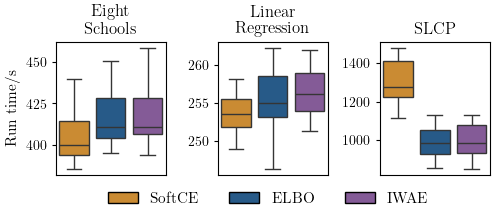

In [5]:
fig = plt.figure(layout='constrained', figsize=(5.15, 2))
axes = fig.subplots(ncols=len(tasks))

for (task_name, times), ax in zip(run_times_dict.items(), axes, strict=True):
    df = pd.DataFrame(times)
    sns.boxplot(df, ax=ax, **box_kwargs)
    ax.set_title(task_name.replace("_", "\n")) 

axes[0].set_ylabel("Run time/s")


handles = [mpatches.Patch(facecolor=v, label=k, edgecolor="black") for k, v in palette.items()]
fig.legend(
    handles=handles,
    bbox_to_anchor=[0.54, -0.15],
    loc='lower center',
    ncol=len(method_names),
    )
for ax in axes:
    ax.tick_params("x", bottom=False)
    ax.xaxis.set_ticklabels([])

fig.tight_layout()
fig.savefig("plots/run_times.pdf")
